# **Customer Segmentation**

This report is intented to analyze customers in the market. Can we cluster customers and know who are valued customers we should target? To answer this, we perform the customers segmentation analysis using customers demography and consumption records and try to explore the relation. 

In the database, we have customers' demographic profiles: ages, genders and locations. On the other hand, we also know each customers' purchase behavior, such as total spend, averaged duration (how ofter they purchased in terms of days) and frequency (how many times). Using unsupervised learning, K-means algorithm, one can cluster the customers and distinguish valued customers. We conclude that most valued customers are from relatively older customers.

In [1]:
import numpy as np
import pandas as pd
import pymysql as mdb
import datetime
from datetime import date
from buyfreq import buyfreq
from revenue import revenue

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pylab
from pylab import *
%matplotlib inline

In [27]:
def calculate_age(born):
    today = date.today()
    return today.year - born.year - ((today.month, today.day) < (born.month, born.day))

''' defining function to make scatter plot'''    
def scatterPlot(size, x1, x2, y, plotTitle):
    fig, ax = plt.subplots(figsize=size)
    s = ax.scatter(x1, x2, s=70, c=y, marker=(5, 0), cmap=plt.cm.jet, linewidths=0, alpha=0.7)
    plt.colorbar(mappable=s, ax=ax)
    ax.set_xlabel('total $ spend', size=20)
    ax.set_ylabel('duration (how often a purchase)', size=20)
    ax.set_title(plotTitle, size=20)
    plt.xlim(-0.3,)
    plt.ylim(-320,)
    
'''3D scatter plot'''
def scatter_3D_plot(X, y):
    fig = plt.figure(1, figsize=(7,6))
    ax = Axes3D(fig, rect=[1, 0, .95, 1], elev=10, azim=134)
    s = ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, s=70)
    ax.set_xlabel('X: total $ spend')
    ax.set_ylabel('Y: interval (days)')
    ax.set_zlabel('Z: frequency')
    plt.show()
    
'''bar plot'''    
def barPlot(size, X, Y1, stdY1, color1, Y2, stdY2, color2):
    ind = np.arange(len(X))  # the x locations for the groups
    width = 0.35             # the width of the bars
    
    fig = plt.figure(figsize = size)
    ax1 = fig.add_subplot(211)
    
    ax1.bar(X, Y1, width, color=color1, yerr=stdY1)
    ax1.set_ylabel('ages', size=17)
    ax1.set_title('ages vs cluster label', size=17)

    ax2 = fig.add_subplot(212)
    ax2.bar(X, Y2, width, color=color2, yerr=stdY2)
    ax2.set_xlabel('cluster label', size=17)
    ax2.set_ylabel('revenues', size=17)
    ax2.set_title('rev vs cluster label', size=17)

    plt.ylim(0,)
    plt.show()

In [3]:
e_store = 1
print ('estore:', e_store)

estore: 1


In [4]:
source_db = mdb.connect(user="xxxxx", host="xxxx", \
db="xxxx", password="xxx",charset='utf8')

## **The Data**

We query the data and prepare the customer profiles **customer_profile**, and the purchase records: **buyfreq_profile** has purchase frequency and purchase interval, and **rev_profile** has total spend (revenue).

In [5]:
with source_db:

    buyfreq_profile = buyfreq(e_store, source_db).buyfreq_profile
    rev_profile = revenue(e_store, source_db).rev_profile

    # ----------------------------------------------------------------                                               
    '''The following is to prepare the customers' profile'''

    select_query = ("select email, birth_date, gender, zipcode ")
    from_query = ("from customer")
    cur = source_db.cursor()
    cur.execute(select_query+from_query+";")
    query_results = cur.fetchall()

    '''customer_profile[email] = (age, gender, zipcode)'''

    customer_profile = {}
    t0 = datetime.datetime.now().date()
    for customer in query_results:
        if customer[1] != None:
            age = calculate_age(customer[1])  ## customer[1] = birth_date                                            
        else:
            age = 0
        customer_profile[customer[0]] = (age, customer[2], customer[3])  ## customer[2]= gender, [3]=zipcode

number of emails (customers) in the estore: 250049
number of transactions in the estore: 250050


### **Ruling out data in which customers' ages are strange**

Above shows number of customers in the profiles and the records. However, we only consider customer whose ages are "normal": we found some customers' ages are several hundreds, 0 or even negative, which are not reasonable. So we do need to clean out the incorrect data.

In [6]:
intev_list = []
freq_list = []
rev_list = []
y = []
for email in rev_profile:
    age = customer_profile[email][0]
    if age > 15 and age < 100:
        y.append(age)
        rev_list.append(rev_profile[email])
        freq_list.append(buyfreq_profile[email][0])
        intev_list.append(buyfreq_profile[email][1])
    else:
        pass
        #if age > 100: print (email, age)

### **Number of customers in the market**

We only consider ages: 15-100. After filtering, the number of customers becomes 

In [7]:
print (len(freq_list), len(rev_list))

233056 233056


In [45]:
np.max(freq_list)

610.0

In [9]:
np.min(intev_list)

-300.0

In [8]:
X = np.column_stack((rev_list, intev_list, freq_list))
print (X.shape)

(233056, 3)


## **Data Visualization: purchase behavior vs ages**

First we visualize the relation between ages and purchase behavior in a two-dimensional chart. Below shows total money spend (X) and duration (Y) vs customers' ages (colors). Each data point denotes a customer. Valued customers are located larger X and smaller Y, meaning spending more money and making more frequent purchase. Note that in y-axis, there are some data points showing that the duration is negative. This means that, those customers only did purchase **ONE** time in the entire record. Strictly speaking, the duration should be defined as infinity, but here I default as -300.

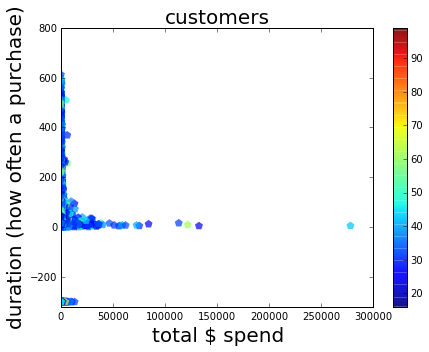

In [30]:
scatterPlot((7,5), X[:,0], X[:,1], y, 'customers')
plt.show()

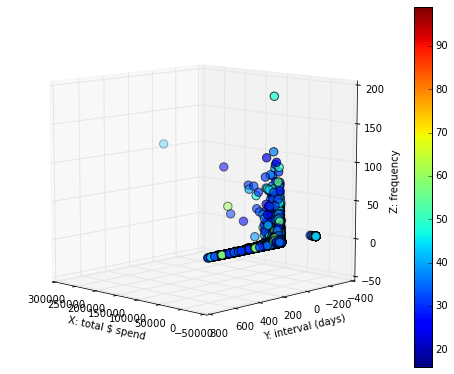

In [24]:
fig = plt.figure(1, figsize=(7,5))
ax = Axes3D(fig, rect=[1, 0, .95, 1], elev=10, azim=134)
s = ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, s=70)
plt.colorbar(mappable=s, ax=ax)
ax.set_xlabel('X: total $ spend')
ax.set_ylabel('Y: interval (days)')
ax.set_zlabel('Z: frequency')
plt.show()

# **k-means clustering using Spark MLlib**

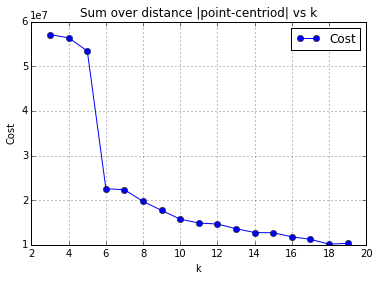

In [6]:
k =[3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]

cost = [57105854.6555, 56349783.4192, 53428804.0964, 22566410.293, 22341721.6237, 19710335.1151, \
        17698969.346, 15737226.6479, 14875657.6322, 14648892.6585, 13604365.2535, 12743003.0202, \
       12694727.9259, 11789389.3647, 11221637.6072, 10143886.351, 10328418.3726]

cos_kmeans = plt.errorbar(k, cost, fmt='-o')

xlabel('k')
ylabel('Cost')
plt.legend([cos_kmeans],['Cost'],loc='upper right')
title('Sum over distance |point-centriod| vs k')
grid(True)

show()

From the chart, the elbow happens at **k=5**. Thus, k=5 is the optimal value of k. In the following we focus on k=5 (5 clusters).

## **k=5**

In [13]:
c_features = pd.read_csv('emporio_cluster_features-k5.csv')
c_features.head()

,label,n_customers,avg_age,sd_age,max_age,min_age,avg_rev,sd_rev,max_rev,min_rev,avg_fq,sd_fq
0,0,232109,36.3065,10.7851,99,16,101.5180,193.8482,2653.491453,0.000000,-144.3886,185.7099
1,1,839,36.4553,9.2906,77,19,5208.3787,2545.7612,13707.051873,2658.082013,16.3135,62.9903
2,2,1,42.0000,0.0000,42,42,278025.7840,0.0000,278025.783968,278025.783968,5.3832,0.0000
3,3,10,36.2000,10.4575,61,25,83388.4189,27317.4753,132589.848685,55888.830570,8.0543,3.4989
4,4,99,34.7475,9.7228,68,21,22399.3122,7526.4148,51243.499673,14061.546435,12.9565,8.0399


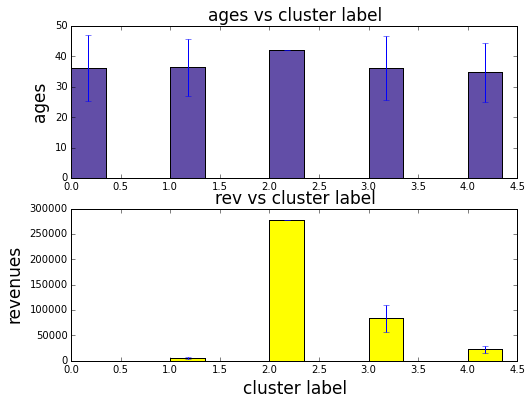

In [14]:
barPlot((8,6), c_features['label'].tolist(), c_features['avg_age'].tolist(), c_features['sd_age'].tolist(),'#624ea7', \
c_features['avg_rev'].tolist(), c_features['sd_rev'].tolist(),'yellow')

Roughly speaking, slightly old customers have more consumption. Customers in Cluster 3 and 4 have lower duration and higher revenuse than the Cluster 0 and Cluster 1. Although the Cluster 3,4 and 0 have similar mean ages. However, in the Cluster 0, customers spent relatively less money and the averaged purchase duration is even negative. From the demography, we can see the customers' ages range from 99 to 16, showing the customers are relatively young or old. 
We believe some very old ages are fake, which could be teenagers to pretend that they are old enough to purchase the products.

Therefore, in business strategy, we should target Clsuter 3 and Cluster 4, to stimulate them browse and purchase our products. It is interesting to note that there is an outlier, where the customer is 42 years old and had very frequent purchase records. It is important to keep track of the customer and analyze the ocuputation.

## **Target valued customers**

Next we target the "valued customers" by focusing on "cluster label >0".

In [15]:
hd = open('emporio.predict')
valued_customer_rev = []
valued_customer_intev = []
valued_customer_freq = []
valued_y = []
for line in hd:
    line = line.replace('\n','').split(',')
    age = line[3]
    if age != '0':
        valued_y.append(float(age))
        valued_customer_rev.append(line[0])
        valued_customer_intev.append(line[1])
        valued_customer_freq.append(line[2])

In [17]:
valued_X = np.column_stack((valued_customer_rev, valued_customer_intev, valued_customer_freq))
print (valued_X.shape)

(949, 3)


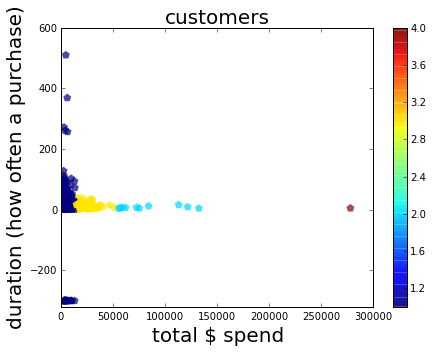

In [29]:
scatterPlot((7,5), valued_X[:,0], valued_X[:,1], valued_y, 'customers')
plt.show()

Cluster 3 and 4 are valued customers. Cluster 2 is a single customer, an outlier. We can keep the targetting customers in these clusters, and try to explore new business on customers who are in Cluster 1.

# **k-means clustering using sklearn**

In [21]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

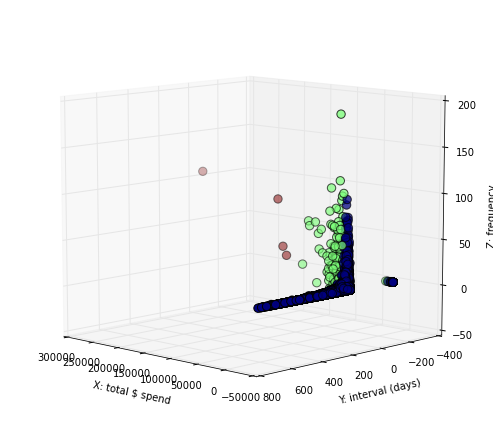

In [22]:
est = KMeans(n_clusters=3,init='k-means++',n_init=20)
est.fit(X)
labels = est.labels_
scatter_3D_plot(X, labels.astype(np.float))

In [ ]:
#print(silhouette_score(X, est.fit_predict(X)))

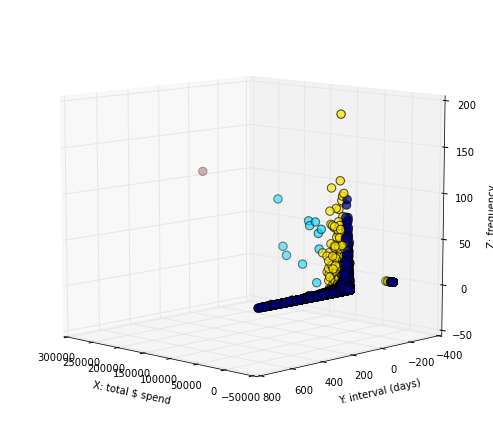

In [23]:
est = KMeans(n_clusters=4,init='k-means++',n_init=20)
est.fit(X)
labels = est.labels_
scatter_3D_plot(X, labels.astype(np.float))

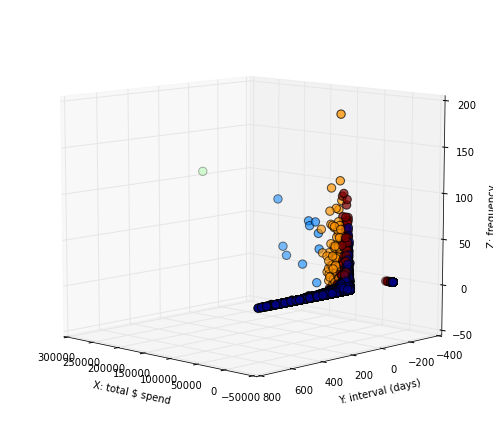

In [25]:
est = KMeans(n_clusters=5,init='k-means++',n_init=20)
est.fit(X)
labels = est.labels_
scatter_3D_plot(X, labels.astype(np.float))

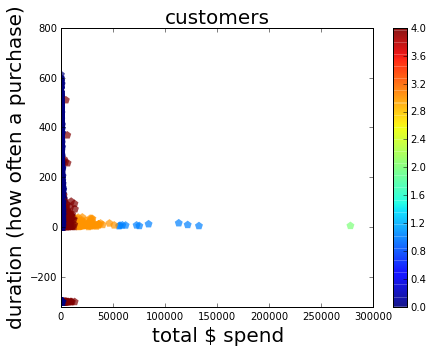

In [28]:
scatterPlot((7,5), X[:,0], X[:,1], labels.astype(np.float), 'customers')
plt.show()

Compare the sklean results and Spark ML, we see the similar pattern to cluster the customers based on the purchase behavior, such as money spent and frequency.

# **Summary**

By clustering, we can explore vlaued customers and design business strategy to follow up. 